In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
np.random.seed(7)
import sqlite3
import pandas as pd
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1K1rpp1cP61oOjKc9CIx-0v4z2SdyOpyi'})
download.GetContentFile('final.sqlite')

In [0]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con)

In [0]:

from sklearn.model_selection import train_test_split
final=final.sort_values(by=['Time'],ascending=False)
final=final.head(121390)
x=final["CleanedText"]
y=final["Score"]


In [0]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
data = pad_sequences(sequences, maxlen=50)


x_train,x_test,y_train,y_test=train_test_split(data, y, test_size=0.2,shuffle=False)

In [19]:
max_review_length = 600
X_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(97112, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [0]:
def plt_dynamic(x, vy, ty):
    plt.figure(figsize=(10,5))
    plt.plot(x, vy, 'b', label="Validation Loss")
    plt.plot(x, ty, 'r', label="Train Loss")
    plt.xlabel('Epochs') 
    plt.ylabel('Binary Crossentropy Loss')
    plt.title('\nBinary Crossentropy Loss VS Epochs')
    plt.legend()
    plt.grid()
    plt.show()

In [0]:
def labelEncoded(Y):
    encoder = LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)
    return encoded_Y

y_test=labelEncoded(y_test)
y_train=labelEncoded(y_train)

## layer 1

In [0]:
# create the model
embedding_vecor_length = 32

#Sequential model
layer_1 = Sequential()

#embedding
layer_1.add(Embedding(20000, embedding_vecor_length, input_length=max_review_length))

# 1st LSTM layer
layer_1.add(LSTM(100))

# Dropout layer
layer_1.add(Dropout(0.3))

# output layer
layer_1.add(Dense(1, activation='sigmoid'))

# model summary
print(layer_1.summary())

# Compiling
layer_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_1 = layer_1.fit(X_train, y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, y_test))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           640000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 693,301
Trainable params: 693,301
Non-trainable params: 0
_______________

Accuracy: 91.27%


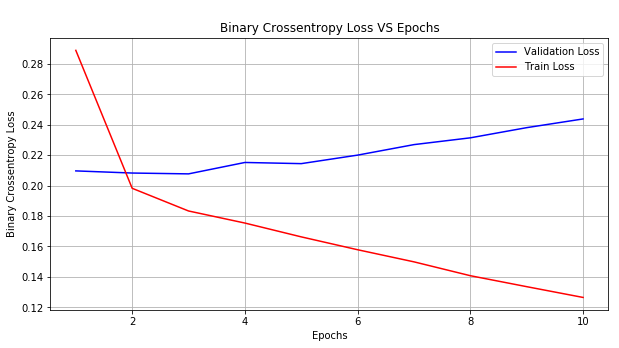

In [0]:
score = layer_1.evaluate(x_test, y_test, verbose=0) 
print('Accuracy:', score[1])
layer_1_test = score[1]
layer_1_train = max(history_1.history['acc'])
x = list(range(1,epochs+1))
# Validation loss
vy = history_1.history['val_loss']
# Training loss
ty = history_1.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

## layer 2

In [0]:
# create the model
embedding_vecor_length = 32

#Sequential model
layer_2 = Sequential()

#embedding layer
layer_2.add(Embedding(20000, embedding_vecor_length, input_length=max_review_length))

#1st LSTM layer
layer_2.add(LSTM(100,return_sequences=True, dropout=0.3, recurrent_dropout=0.3))

#2nd LSTM layer
layer_2.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

#output layer
layer_2.add(Dense(1, activation='sigmoid'))

#summary
print(layer_2.summary())

# Compiling
layer_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_2 = layer_2.fit(X_train, y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, y_test))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 773,701
Trainable params: 773,701
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 145668 samples, val

Accuracy: 90.34%


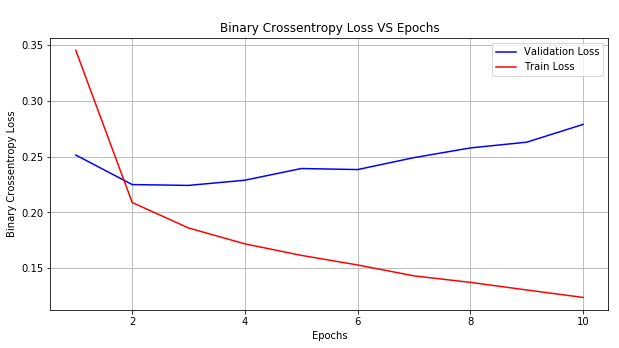

In [0]:
score = layer_2.evaluate(x_test, y_test, verbose=0) 
print('Accuracy:', score[1])
layer_2_test = score[1]
layer_2_train = max(history_2.history['acc'])
x = list(range(1,epochs+1))
# Validation loss
vy = history_2.history['val_loss']
# Training loss
ty = history_2.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

## layer 3

In [0]:
embedding_vecor_length = 32

#Sequential model
layer_3 = Sequential()

#embedding model
layer_3.add(Embedding(20000, embedding_vecor_length, input_length=max_review_length))

#1st LSTM layer
layer_3.add(LSTM(100,return_sequences=True, dropout=0.3, recurrent_dropout=0.3))

#2nd LSTM layer
model_3.add(LSTM(100,return_sequences=True, dropout=0.3, recurrent_dropout=0.3))

#3rd LSTM layer
layer_3.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

#output layer
layer_3.add(Dense(1, activation='sigmoid'))

#summary
print(layer_3.summary())

#Compiling
layer_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fitting the model
history_3 = layer_3.fit(X_train, y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 600, 32)           640000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 600, 100)          80400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 854,101
Trainable params: 854,101
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 97112 samples, validate on 24278 samples
Epoch 1/10
97112/97112 [=========

Accuracy: 92.18%


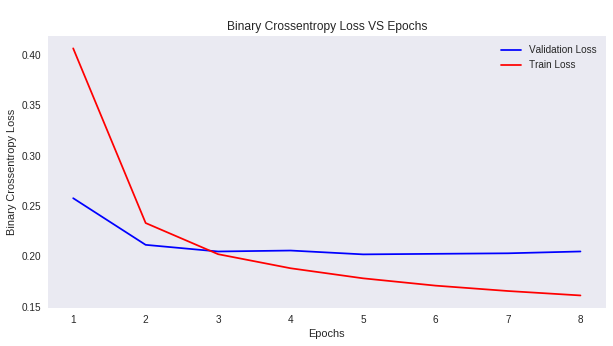

In [0]:
score = layer_3.evaluate(x_test, y_test, verbose=0) 
print('Accuracy:', score[1])
layer_3_test = score[1]
layer_3_train = max(history_7.history['acc'])
x = list(range(1,epochs+1))
# Validation loss
vy = history_3.history['val_loss']
# Training loss
ty = history_3.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

## LSTMS
| Layer |accuracy Test
|------|------|
|Layer 1|91.27%|
|Layer 2|90.34%|
|Layer 3|92.18%|